In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
import cmocean
import pickle
from scipy import interpolate
from scipy import integrate
from scipy.interpolate import griddata 
from tqdm.notebook import tqdm
from altimetry_tools import Haversine, smooth_tracks, coarsen, specsharp

In [2]:
# load dataset
x1 = xr.open_dataset('/Users/jakesteinberg/Desktop/neverworld/snapshots_00032505.nc', decode_times=False)  
# x1

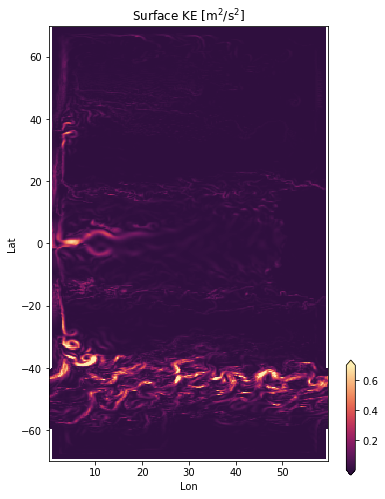

In [3]:
# sample plot of Surface KE 
f, ax = plt.subplots(1, 1, figsize=(5,8))
levs = np.linspace(7*10**(-8), 7*10**(-1), 100)
axp = ax.pcolormesh(x1.xh, x1.yh, x1.KE.values[-1, 0], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
ax.set_title('Surface KE [m$^2$/s$^2$]')
ax.set_ylabel('Lat')
ax.set_xlabel('Lon')
cbpos = [0.95, 0.1, 0.025, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')
plt.show()

In [4]:
# extract meridional slice and compute distance 
lat = x1.yh.values
lon = x1.xh.values
lat_uv = x1.yh.values
# lon_uv = x1.xq.values
time = x1.time.values
e_0 = x1.e.values
e = e_0

lon_slice = np.array([10.125])
lon_slice_uv = np.array(10.25)
KE_slice = np.squeeze(x1.KE.values[:, 0, :, x1.xh == lon_slice])  # [MxN] M = time, N = distance 
e_slice = np.squeeze(e[:, 0, :, x1.xh == lon_slice])
u_slice = np.squeeze(x1.u.values[:, 0, :, x1.xq == lon_slice_uv])
v_slice = np.squeeze(x1.v.values[:, 0, :, x1.xh == lon_slice])

dist = np.nan * np.ones(len(lat))
dist_u = np.nan * np.ones(len(lat))
dist[0] = 0
dist_u[0] = 0
# LAT (for each grid step in latitude, compute distance)
for i in range(1, len(lat)):
    # dist[i] = Haversine(lat[0], lon_slice[0], lat[i], lon_slice[0])  # in km
    dx = 1852 * 60 * np.cos(np.deg2rad(lat[i])) * (lon_slice[0] - lon_slice[0])
    dy = 1852 * 60 * (lat[i] - lat[i - 1]) 
    dist[i] = np.sqrt(dx**2 + dy**2) 
# LON (at each latitude, compute distance in the zonal direction )
dist_lon = np.zeros((len(lat), len(lon)))
for l in range(len(lat)):
    for i in range(1, len(lon)):
        dx = 1852 * 60 * np.cos(np.deg2rad(lat[l])) * (lon[i] - lon[i - 1])
        dy = 1852 * 60 * (lat[l] - lat[l]) 
        dist_lon[l, i] = np.sqrt(dx**2 + dy**2) 
# separate velocity grid 
for i in range(1, len(lat)):
    dist_u[i] = Haversine(lat[0], lon_slice[0], lat[i], lon_slice[0])  # in km
    
dist_sum = np.cumsum(dist)
dist_lon_sum = np.cumsum(dist_lon, axis=1)
# 1/4 degree model (no real need to turn into km)      
print(str((dist_sum[2] - dist_sum[1])/1000) + ' km grid step')

27.78 km grid step


In [5]:
# place u,v on KE grid 
u_lon = x1.xq.values
v_lat = x1.yq.values
u_reg = np.nan * np.ones((len(time), len(lat), len(lon)))
v_reg = np.nan * np.ones((len(time), len(lat), len(lon)))
for t in tqdm(range(len(time))):
    this_u = np.squeeze(x1.u.values[t, 0, :, :].copy())  # needs to be interpolated in lon direction
    this_v = np.squeeze(x1.v.values[t, 0, :, :].copy())  # needs to be interpolated in lat direction 
    for uu in range(len(lat)):
        u_reg[t, uu, :] = np.interp(lon, u_lon, this_u[uu, :])
    for vv in range(len(lon)):
        v_reg[t, :, vv] = np.interp(lat, v_lat, this_v[:, vv])

In [6]:
# try and place u,v, KE on regular cartesian grid 
time = x1.time.values
lon = x1.xh.values
lat = x1.yh.values
x_grid = np.arange(0, np.nanmax(dist_lon_sum), 27780)  # force same lon grid step as lat grid step 
u_xy_grid = np.nan * np.ones((len(time), len(lat), len(x_grid)))
v_xy_grid = np.nan * np.ones((len(time), len(lat), len(x_grid)))
ke_xy_grid = np.nan * np.ones((len(time), len(lat), len(x_grid)))
e_xy_grid = np.nan * np.ones((len(time), len(lat), len(x_grid)))
for t in tqdm(range(len(time))):
    this_u = np.squeeze(x1.u.values[t, 0, :, :].copy()) 
    this_v = np.squeeze(x1.v.values[t, 0, :, :].copy()) 
    this_ke = np.squeeze(x1.KE.values[t, 0, :, :].copy()) 
    this_e = np.squeeze(x1.e.values[t, 0, :, :].copy()) 
    for i in range(len(lat)):
        good = np.where(~np.isnan(this_ke[i, :]))[0]
        if len(good) > 5:
            this_xx_i = np.where(x_grid <= np.nanmax(dist_lon_sum[i, good]))[0]
            this_xx = x_grid[this_xx_i]
            ke_xy_grid[t, i, this_xx_i] = np.interp(this_xx, dist_lon_sum[i, good], this_ke[i, good])
            u_xy_grid[t, i, this_xx_i] = np.interp(this_xx, dist_lon_sum[i, good], this_u[i, good])
            v_xy_grid[t, i, this_xx_i] = np.interp(this_xx, dist_lon_sum[i, good], this_v[i, good])
            e_xy_grid[t, i, this_xx_i] = np.interp(this_xx, dist_lon_sum[i, good], this_v[i, good])

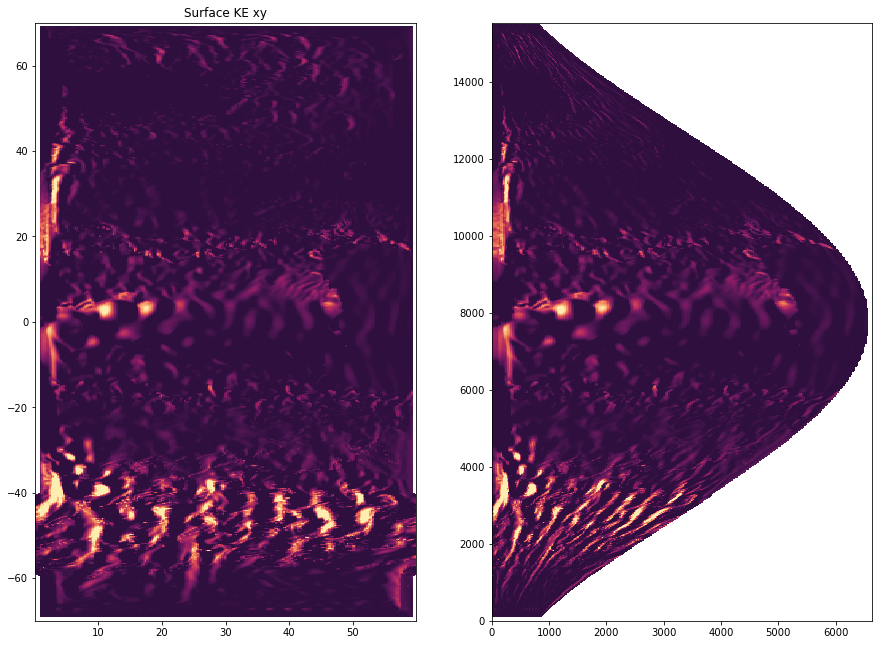

In [7]:
# recheck Surface KE on xy grid 
t_i = 10
f, (ax, ax2) = plt.subplots(1, 2, figsize=(15,11))
levs = np.linspace(7*10**(-8), 7*10**(-1), 100)
# levs = np.linspace(-2, 1, 100)
# ax.pcolormesh(x1.xh, x1.yh, x1.KE.values[t_i, 0], cmap = cmocean.cm.matter_r, \
#               zorder=0, vmin=levs[0], vmax=levs[-1])
# ax.pcolormesh(x1.xq, x1.yh, x1.u.values[t_i, 0], cmap = cmocean.cm.matter_r, \
#               zorder=0, vmin=levs[0], vmax=levs[-1])
ax.pcolormesh(x1.xh, x1.yq, x1.v.values[t_i, 0], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
ax.set_title('Surface u')
ax2.pcolormesh(dist_lon_sum/1000, dist_sum/1000, v_xy_grid[t_i, :, :], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
ax.set_title('Surface KE xy')
plt.show()

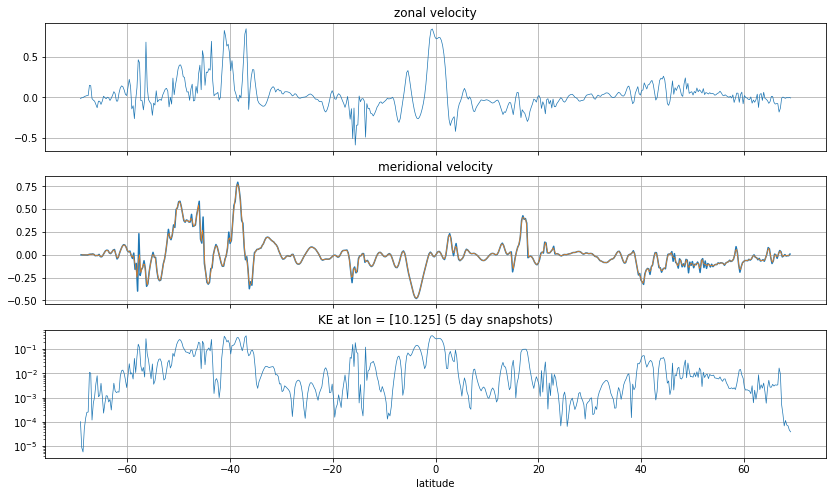

In [8]:
# sample KE (random snapshots to see variability)
f, (axu, axv, ax) = plt.subplots(3, 1, sharex=True, figsize=(14, 8))
time_snaps  = [0]  # , 10, 20, 30]
for i in time_snaps:  #  range(np.shape(KE_slice)[0]):
    axu.plot(lat, np.squeeze(u_reg[i, :, x1.xh == lon_slice]), linewidth=0.7)
    axv.plot(v_lat, np.squeeze(x1.v.values[i, 0, :, x1.xh == lon_slice]), linewidth=1.5)
    axv.plot(lat, np.squeeze(v_reg[i, :, x1.xh == lon_slice]), linewidth=.7)
    ax.plot(lat, KE_slice[i, :], linewidth=0.7)
# ax.set_ylim([10**(-5), 10])
ax.set_yscale('log')
# ax.set_ylim([-2, 2])
ax.set_title('KE at lon = ' + str(lon_slice) + ' (5 day snapshots)')
ax.set_xlabel('latitude')
axu.set_title('zonal velocity')
axv.set_title('meridional velocity')
ax.grid()
axu.grid()
axv.grid()
plt.show()

In [9]:
# take meridional slice and analyze as a I along-track altimeter measurements 
# reformat data to serve as adequate input into filtering and coarsening [filtEr() library]
dist_0 = []
dist_0.append(dist_sum)
u_0 = []
u_0.append(u_slice)
lon_0 = []
lon_0.append(lon_slice * np.ones(len(lat)))
lat_0 = []
lat_0.append(lat)
time_0 = []
time_0.append(time)
track_0 = []
track_0.append(lon_slice * np.ones(len(lat)))

In [10]:
# Filter 
coarsening_factor = 4
filter_choice = 'sharp'  # gaussian 
nyquist_wavelength = np.pi
u_smooth, u_smooth = smooth_tracks(dist_0, u_0, u_0, lon_0, lat_0, time_0, \
              track_0, coarsening_factor, filter_choice, nyquist_wavelength)

Filter Half-Width = 
11 [0.16561428 0.15722541 0.1338254  0.10022574]
12 [0.16559081 0.15720193 0.13380193 0.10020227]
converged //
------------------------------------------------------------
for a coarsening factor of 4, recommend:
-- filter width of 25 grid cells (here = 694500.0 km)
------------------------------------------------------------


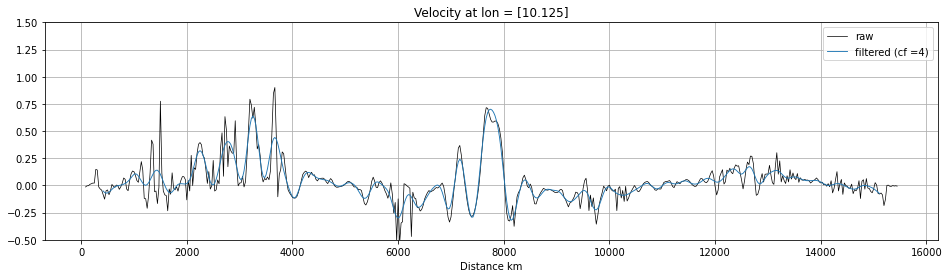

In [11]:
# plot filtered result 
f, ax = plt.subplots(1, 1, figsize=(16, 4))
for i in range(1):  #  range(np.shape(KE_slice)[0]):
    ax.plot(dist_sum/1000.0, u_slice[i, :], color='k', linewidth=0.7, label='raw')
    ax.plot(dist_sum/1000.0, u_smooth[0][i, :], linewidth=0.9, label='filtered (cf =' + str(coarsening_factor) + ')')
# ax.set_ylim([10**(-5), 10])
# ax.set_yscale('log')
ax.set_ylim([-.5, 1.5])
ax.set_title('Velocity at lon = ' + str(lon_slice))
ax.set_xlabel('Distance km')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.grid()
plt.show()

In [12]:
# Coarsen 
coarse_grid_out, coarse_lon_out, coarse_lat_out, coarse_sig_out = coarsen(dist_0, lon_0, lat_0, \
                                                                          coarsening_factor, u_smooth)

/Users/jakesteinberg/Documents/CPT/altimetry_tools.py:395: RuntimeWarning: Mean of empty slice
  (this_dist < coarse_grid[j])], axis=1)


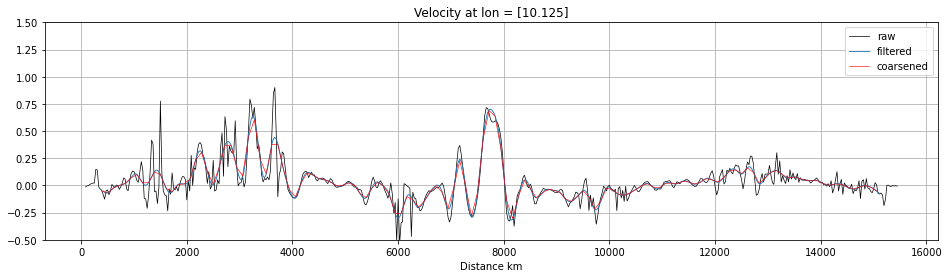

In [13]:
# plot combined results 
f, ax = plt.subplots(1, 1, figsize=(16, 4))
for i in range(1):  #  range(np.shape(KE_slice)[0]):
    ax.plot(dist_sum/1000.0, u_slice[i, :], color='k', linewidth=0.7, label='raw')
    ax.plot(dist_sum/1000.0, u_smooth[0][i, :], linewidth=0.9, label='filtered')
    ax.plot(coarse_grid_out[0]/1000.0, coarse_sig_out[0][i, :], color='r', linewidth=0.6, label='coarsened')
# ax.set_ylim([10**(-5), 10])
# ax.set_yscale('log')
ax.set_ylim([-.5, 1.5])
ax.set_title('Velocity at lon = ' + str(lon_slice))
ax.set_xlabel('Distance km')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.grid()
plt.show()

In [14]:
# load in j2 data for qualitative reference 
this_sat = 'j2'
filter_type = 'sharp'
load_sat = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
                            this_sat + '_' + filter_type + '_processed.p', 'rb'))
dist_sat = load_sat['dist']
vel_sat = load_sat['vel_adt']
track_sat = load_sat['track']
t_i = np.array([124])  # en 3 # J2 24,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
good_sat = np.where(track_sat == t_i)[0][0]

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Degrees of freedom <= 0 for slice.
  after removing the cwd from sys.path.


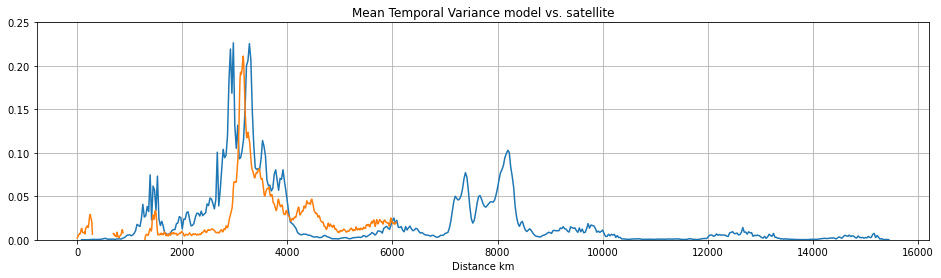

In [15]:
# show temporal variability along meridional section 
f, ax = plt.subplots(1, 1, figsize=(16,4))
ax.plot(dist_sum/1000.0, np.nanvar(u_slice, axis=0))
ax.plot(dist_sat[good_sat], np.nanvar(vel_sat[good_sat], axis=0))
ax.set_ylim([0, 0.25])
# ax.set_xlim([15000, 20000])
ax.set_xlabel('Distance km')
ax.set_title('Mean Temporal Variance model vs. satellite')
ax.grid()
plt.show()

In [16]:
# test application of sharp  filter
def filterSpec(N,dxMin,Lf,shape="Gaussian", X=np.pi):
    """
    Inputs: 
    N is the number of total steps in the filter
    dxMin is the smallest grid spacing - should have same units as Lf
    Lf is the filter scale, which has different meaning depending on filter shape
    shape can currently be one of two things:
        Gaussian: The target filter has kernel ~ e^{-|x/Lf|^2}
        Taper: The target filter has target grid scale Lf. Smaller scales are zeroed out. 
               Scales larger than pi*Lf/2 are left as-is. In between is a smooth transition.
    Note that the above are properties of the *target* filter, which are not the same as the actual filter.
    
    Outputs:
    NL is the number of Laplacian steps
    sL is s_i for the Laplacian steps; units of sL are one over the units of dxMin and Lf, squared
    NB is the number of Biharmonic steps
    sB is s_i for the Biharmonic steps; units of sB are one over the units of dxMin and Lf, squared
    """
    # Code only works for N>2
    if N <= 2:
        print("Code requires N>2")
        return 
    # First set up the mass matrix for the Galerkin basis from Shen (SISC95)
    M = (np.pi/2)*(2*np.eye(N-1) - np.diag(np.ones(N-3),2) - np.diag(np.ones(N-3),-2))
    M[0,0] = 3*np.pi/2
    # The range of wavenumbers is 0<=|k|<=sqrt(2)*pi/dxMin. Nyquist here is for a 2D grid. 
    # Per the notes, define s=k^2.
    # Need to rescale to t in [-1,1]: t = (2/sMax)*s -1; s = sMax*(t+1)/2
    sMax = 2*(np.pi/dxMin)**2
    # Set up target filter
    if shape == "Gaussian":
        F = lambda t: np.exp(-(sMax*(t+1)/2)*(Lf/2)**2)
    elif shape == "Taper":
        # F = interpolate.PchipInterpolator(np.array([-1,(2/sMax)*(2/Lf)**2 -1,(2/sMax)*(np.pi/Lf)**2 -1,2]),np.array([1,1,0,0]))
        F = interpolate.PchipInterpolator(np.array([-1,(2/sMax)*(np.pi/(X*Lf))**2 -1,(2/sMax)*(np.pi/Lf)**2 -1,2]),np.array([1,1,0,0]))
        # 2nd entry = (2/sMax)*(np.pi/(X*Lf))**2 -1  X = width of transition (~np.pi)
        # 3rd entry = nyquist wavelength on grid I'm filtering to
    else:
        print("Please input a valid shape")
        return
    # Compute inner products of Galerkin basis with target
    b = np.zeros(N-1)
    points, weights = np.polynomial.chebyshev.chebgauss(N+1)
    for i in range(N-1):
        tmp = np.zeros(N+1)
        tmp[i] = 1
        tmp[i+2] = -1
        phi = np.polynomial.chebyshev.chebval(points,tmp)
        b[i] = np.sum(weights*phi*(F(points)-((1-points)/2 + F(1)*(points+1)/2)))
    # Get polynomial coefficients in Galerkin basis
    cHat = np.linalg.solve(M,b)
    # Convert back to Chebyshev basis coefficients
    p = np.zeros(N+1)
    p[0] = cHat[0] + (1+F(1))/2
    p[1] = cHat[1] - (1-F(1))/2
    for i in range(2,N-1):
        p[i] = cHat[i] - cHat[i-2]
    p[N-1] = -cHat[N-3]
    p[N] = -cHat[N-2]
    # Now plot the target filter and the approximate filter
    x = np.linspace(-1,1,251)
    k = np.sqrt((sMax/2)*(x+1))
    
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 4))
    ax1.plot(k,F(x),k,np.polynomial.chebyshev.chebval(x,p))
    ax2.plot(k,F(x)-np.polynomial.chebyshev.chebval(x,p))
    plt.show()
    # Get roots of the polynomial
    r = np.polynomial.chebyshev.chebroots(p)
    # convert back to s in [0,sMax]
    s = (sMax/2)*(r+1)
    # Separate out the real and complex roots
    NL = np.size(s[np.where(np.abs(np.imag(r)) < 1E-12)]) 
    sL = np.real(s[np.where(np.abs(np.imag(r)) < 1E-12)])
    NB = (N - NL)//2
    sB_re,indices = np.unique(np.real(s[np.where(np.abs(np.imag(r)) > 1E-12)]),return_index=True)
    sB_im = np.imag(s[np.where(np.abs(np.imag(r)) > 1E-12)])[indices]
    sB = sB_re + sB_im*1j
    return NL,sL,NB,sB

grid step = 27.78km
filtering factor = 4


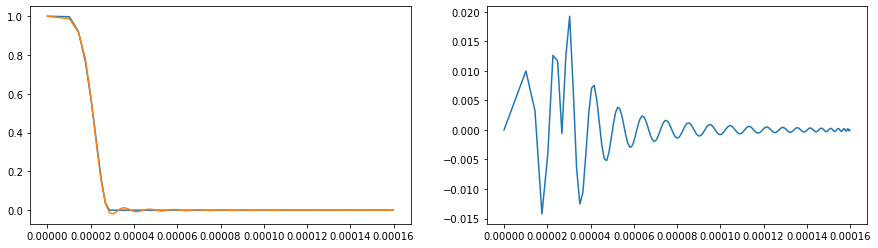

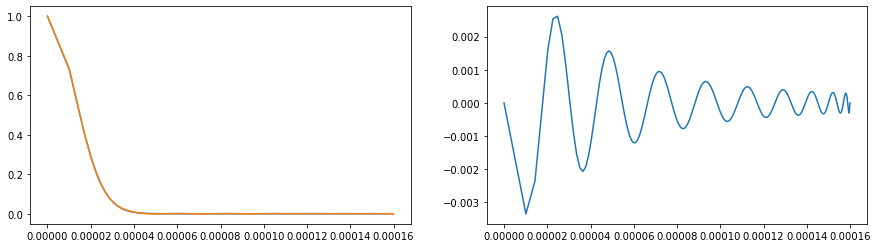

39 1
17 1


In [17]:
N = 41 # filter steps
N_g = 19
dxMin = dist_sum[2] - dist_sum[1]  # grid distance 
print('grid step = ' + str(dxMin/1000.0) + 'km')
coarsening_factor = 4
Lf = dxMin*coarsening_factor  # filter scale 
print('filtering factor = ' + str(coarsening_factor))
NL,sL,NB,sB = filterSpec(N, dxMin, Lf, "Taper", X=np.pi)
NL_g,sL_g,NB_g,sB_g = filterSpec(N_g, dxMin, Lf, "Gaussian", X=np.pi)
print(NL,NB)
print(NL_g, NB_g)

In [19]:
# application of laplacian/biharmonic to 1d track at one time for testing 
from scipy.ndimage import laplace 

def Biharmonic(dxMin, data):
    B = np.convolve((1/dxMin**4)*np.array([1,-4,6,-4,1]), data)
    if len(B) > len(data):
        B = B[2:-2]
    return B

# FILTER u 
dataBar = u_slice[0, :].copy() # Initialize the filtering process
for i in range(NL):
    tempL = (1/(dxMin**2))*laplace(dataBar, output=None, mode='reflect', cval=0.0)
    dataBar = dataBar + (1/sL[i])*tempL # Update filtered field
for i in range(NB):
    tempL = (1/(dxMin**2))*laplace(dataBar, output=None, mode='reflect', cval=0.0)
    # tempB = # Biharmonic(dxMin, dataBar) # Compute Biharmonic. If boundary conditions permit you could replace this by
    tempB = (1/(dxMin**2))*laplace(tempL, output=None, mode='reflect', cval=0.0)
    dataBar = dataBar + (2*np.real(sB[i])/(np.abs(sB[i])**2))*tempL + (1/(np.abs(sB[i])**2))*tempB
    
# -- GAUSSIAN FILTER u 
dataBar_g = u_slice[0, :].copy()
for i in range(NL_g):
    tempL_g = (1/(dxMin**2))*laplace(dataBar_g, output=None, mode='reflect', cval=0.0)
    dataBar_g = dataBar_g + (1/sL_g[i])*tempL_g # Update filtered field
for i in range(NB_g):
    tempL_g = (1/(dxMin**2))*laplace(dataBar_g, output=None, mode='reflect', cval=0.0)
    tempB_g = Biharmonic(dxMin, dataBar_g) # Compute Biharmonic. 
    dataBar_g = dataBar_g + (2*np.real(sB_g[i])/(np.abs(sB_g[i])**2))*tempL_g + (1/(np.abs(sB_g[i])**2))*tempB_g

Filter Half-Width = 
11 [0.16561428 0.15722541 0.1338254  0.10022574]
12 [0.16559081 0.15720193 0.13380193 0.10020227]
converged //
------------------------------------------------------------
for a coarsening factor of 4, recommend:
-- filter width of 25 grid cells (here = 694500.0 km)
------------------------------------------------------------


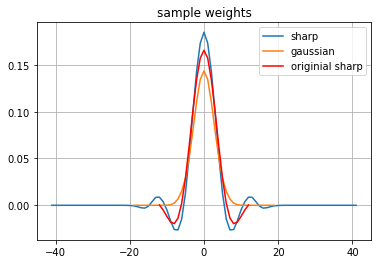

In [21]:
# comparisons to 'old' method
nyquist_wavelength = np.pi
filter_weights, jj = specsharp(dxMin, coarsening_factor, nyquist_wavelength)
# test_convolve = np.convolve(test_data, filter_weights)

#  old method (sample to show filter weights (don't need these in the above application of this method))
L = (1/(dxMin**2))*np.array([1,-2,1])
B = (1/(dxMin**4))*np.array([1,-4,6,-4,1])
I = np.array([0,1,0])
w = ((1/(dxMin**2))*2*np.real(sB)*np.array([0,1,-2,1,0]) + B)/np.abs(sB)**2
w[2] = w[2] + 1
for i in range(NL):
    w = np.convolve(I + (1/sL[i])*L,w)

# new method doesnt seem to work 
# L3 = (1/(dxMin**2))**np.array([1,-2,1]) # The 1E4 in this line is 1/h^2 where h=0.01 is the assumed grid spacing.
# L5 = (1/(dxMin**2))**np.array([0,1,-2,1,0])
# B = (1/(dxMin**4))**np.array([1,-4,6,-4,1]) # The 1E8 in this line is 1/h^4
# I3 = np.array([0,1,0])
# I5 = np.array([0,0,1,0,0])
# w = 1
# for i in range(NL):
#     w = np.convolve(I3 + (1/sL[i])*L3,w)
# for i in range(NB):
#     w = np.convolve(I5 + (2*np.real(sB[i])/np.abs(sB[i])**2)*L5 + (1/np.abs(sB[i])**2)*B, w)
    
# -- sample to show gaussian filter weights (don't need these in the above application of this method)
w_g = ((1/(dxMin**2))*2*np.real(sB_g)*np.array([0,1,-2,1,0]) + B)/np.abs(sB_g)**2
w_g[2] = w_g[2] + 1
for i in range(NL_g):
    w_g = np.convolve(I + (1/sL_g[i])*L, w_g)
    
f, ax = plt.subplots()
ax.plot(np.arange(-np.int(np.floor(len(w)/2)), np.int(np.floor(len(w)/2)) + 1), w, label='sharp')
ax.plot(np.arange(-np.int(np.floor(len(w_g)/2)), np.int(np.floor(len(w_g)/2)) + 1), w_g, label='gaussian')
ax.plot(np.arange(-np.int(np.floor(len(filter_weights)/2)), np.int(np.floor(len(filter_weights)/2)) + 1), \
                   filter_weights, color='r', label='originial sharp')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.set_title('sample weights')
ax.grid()
plt.show()

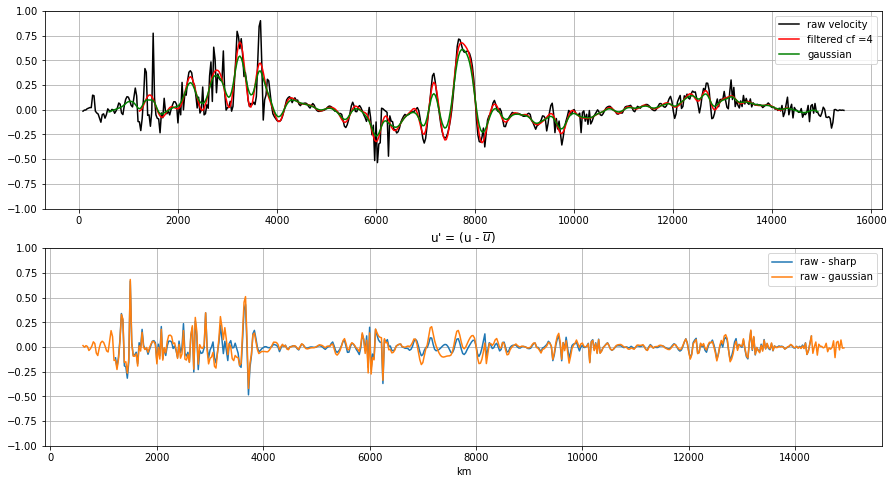

In [23]:
# trim_edge = np.int((len(test_convolve) - len(dist_sum))/2)
f, (ax, ax2) = plt.subplots(2,1,figsize=(15,8))
ax.plot(dist_sum/1000, 1*u_slice[0, :], color='k', label='raw velocity')
ax.plot(dist_sum/1000, dataBar, color='r', label='filtered cf =' + str(coarsening_factor))
ax.plot(dist_sum/1000, dataBar_g, color='g', label='gaussian')
# ax.plot(dist_sum/1000, test_convolve[trim_edge:-trim_edge], color='b', label='original sharp')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.set_ylim([-1, 1])
ax.grid()
ax2.plot(dist_sum/1000, u_slice[0, :] - dataBar, label='raw - sharp')
ax2.plot(dist_sum/1000, u_slice[0, :] - dataBar_g, label='raw - gaussian')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)
ax2.set_title("u' = (u - $\overline{u}$)")
ax2.set_xlabel('km')
ax2.set_ylim([-1, 1])
ax2.grid()
plt.show()

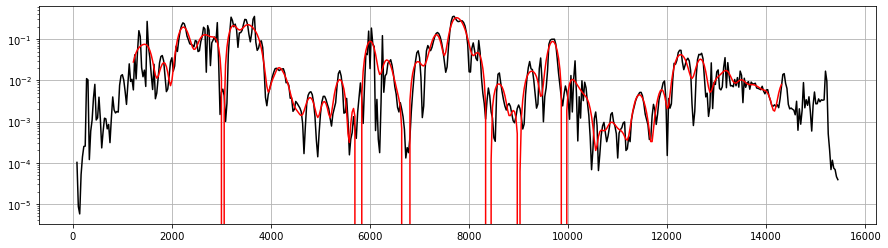

In [24]:
# for reference, filter KE (show how to get negative KE)
# FILTER KE 
dataBar_ke = KE_slice[0, :].copy() # Initialize the filtering process
for i in range(NL):
    tempL = (1/dxMin**2)*laplace(dataBar_ke, output=None, mode='reflect', cval=0.0)
    dataBar_ke = dataBar_ke + (1/sL[i])*tempL # Update filtered field
for i in range(NB):
    tempL = (1/dxMin**2)*laplace(dataBar_ke, output=None, mode='reflect', cval=0.0)
    tempB = Biharmonic(dxMin, dataBar_ke) # Compute Biharmonic. If boundary conditions permit you could replace this by
                                # tempB = Laplacian(tempL)
    dataBar_ke = dataBar_ke + (2*np.real(sB[i])/(np.abs(sB[i])**2))*tempL + (1/(np.abs(sB[i])**2))*tempB

f, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(dist_sum/1000, KE_slice[0, :], color='k', label='raw KE')
ax.plot(dist_sum/1000, dataBar_ke, color='r', label='filtered cf =' + str(coarsening_factor))
ax.set_yscale('log')
ax.grid()
plt.show()

In [25]:
# create temporary nanmask
mask_u = np.zeros((np.shape(u_xy_grid[t, :, :])), dtype=bool)
mask_v = np.zeros((np.shape(v_xy_grid[t, :, :])), dtype=bool)
for i in range(np.shape(u_xy_grid[t, :, :])[0]):
    this_row_u = u_xy_grid[t, i, :]
    this_row_v = v_xy_grid[t, i, :]
    mask_u[i, np.isfinite(this_row_u)] = True 
    mask_v[i, np.isfinite(this_row_v)] = True 

In [77]:
# now apply in both lat/lon directions (on regularly/evenly spaced grid so we can take the laplacian)
# careful of what I want to filter  

u_filtered = np.nan * np.ones(np.shape(u_xy_grid))
v_filtered = np.nan * np.ones(np.shape(v_xy_grid))
for t in tqdm(range(len(time))):
    uBar_master = u_xy_grid[t, :, :].copy()   # Initialize the filtering process
    uBar_master[np.isnan(uBar_master)] = 0
    # uBar_master2 = np.ma.array(uBar_master, mask=mask_u)
    vBar_master = v_xy_grid[t, :, :].copy()   # Initialize the filtering process
    vBar_master[np.isnan(vBar_master)] = 0
    
    dataBar = uBar_master.copy()
    for i in range(NL):
        tempL = (1/dxMin**2)*laplace(dataBar, output=None, mode='reflect', cval=0.0)
        dataBar = dataBar + (1/sL[i])*tempL # Update filtered field
    for i in range(NB):
        tempL = (1/dxMin**2)*laplace(dataBar, output=None, mode='reflect', cval=0.0)
        # tempB = Biharmonic(dxMin, dataBar) # Compute Biharmonic. If boundary conditions permit you could replace this by
        tempB = (1/dxMin**2)*laplace(tempL)
        dataBar = dataBar + (2*np.real(sB[i])/(np.abs(sB[i])**2))*tempL + (1/(np.abs(sB[i])**2))*tempB
    pre_out = dataBar
    pre_out[np.abs(pre_out) < 0.000001] = np.nan
    u_filtered[t, :, :] = pre_out
    
    dataBar2 = vBar_master.copy()
    for i in range(NL):
        tempL = (1/dxMin**2)*laplace(dataBar2, output=None, mode='reflect')
        dataBar2 = dataBar2 + (1/sL[i])*tempL # Update filtered field
    for i in range(NB):
        tempL = (1/dxMin**2)*laplace(dataBar2, output=None, mode='reflect')
        # tempB = Biharmonic(dxMin, dataBar) # Compute Biharmonic. If boundary conditions permit you could replace this by
        tempB = (1/dxMin**2)*laplace(tempL)
        dataBar2 = dataBar2 + (2*np.real(sB[i])/(np.abs(sB[i])**2))*tempL + (1/(np.abs(sB[i])**2))*tempB
    pre_out2 = dataBar2
    pre_out2[np.abs(pre_out2) < 0.000001] = np.nan
    v_filtered[t, :, :] = pre_out2
    
    del dataBar, dataBar2

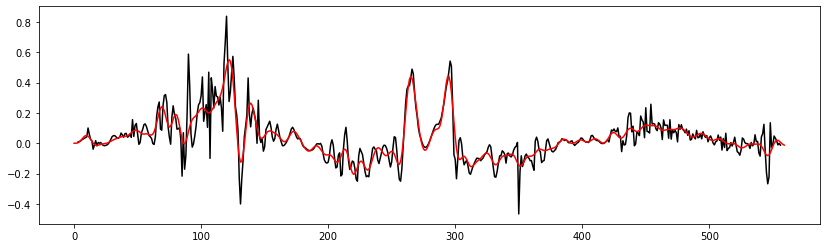

In [75]:
t_test = 10
f, ax = plt.subplots(1,1,figsize=(14,4))
ax.plot(np.arange(0, len(u_xy_grid[0, :, 10])), u_xy_grid[t_test, :, 45], color='k')
ax.plot(np.arange(0, len(u_xy_grid[0, :, 10])), u_filtered[t_test, :, 45], color='r')
plt.show()

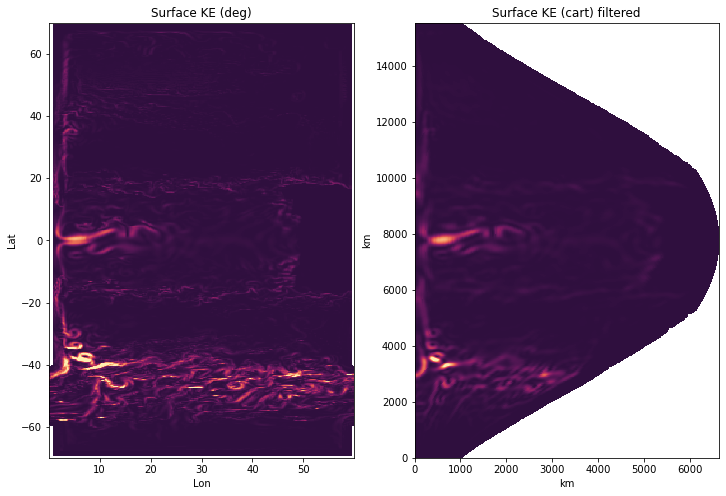

In [78]:
t_i = 20
f, (ax, ax2) = plt.subplots(1, 2, figsize=(12,8))
levs = np.linspace(7*10**(-8), 7*10**(-1), 100)
# levs = np.linspace(-.75, .75, 100)
ax.pcolormesh(x1.xh, x1.yh, x1.KE.values[t_i, 0], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
ax.set_title('Surface KE (deg)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax2.pcolormesh(dist_lon_sum/1000, dist_sum/1000, \
               (0.5)*(u_filtered[t_i, :, :]**2 + v_filtered[t_i, :, :]**2), cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
ax2.set_title('Surface KE (cart) filtered')
ax2.set_xlabel('km')
ax2.set_ylabel('km')
# ax3.pcolormesh(dist_lon_sum/1000, dist_sum/1000, v_filtered[t_i, :, :], cmap = cmocean.cm.matter_r, \
#               zorder=0, vmin=levs[0], vmax=levs[-1])
# ax3.set_title('Surface v (cart) filtered')
# ax3.set_xlabel('km')
# ax3.set_ylabel('km')
plt.show()

In [79]:
# flip back to lat/lon grid 
u_filtered_latlon_grid = np.nan * np.ones((len(time), len(lat), len(lon)))
v_filtered_latlon_grid = np.nan * np.ones((len(time), len(lat), len(lon)))
for t in tqdm(range(len(time))):
    this_u = u_filtered[t, :, :]
    this_v = v_filtered[t, :, :]
    for i in range(len(lat)):
        good = np.where(~np.isnan(this_u[i, :]))[0]
        good_v = np.where(~np.isnan(this_v[i, :]))[0]
        if len(good) > 5:
            this_xyog_i = np.where(dist_lon_sum[i, :] <= np.nanmax(x_grid[good]))[0]  # put back onto og xy
            this_xyog = dist_lon_sum[i, this_xyog_i]
            u_filtered_latlon_grid[t, i, this_xyog_i] = np.interp(this_xyog, x_grid[good], this_u[i, good])
        if len(good_v) > 5:
            this_xyog_i = np.where(dist_lon_sum[i, :] <= np.nanmax(x_grid[good]))[0]  # put back onto og xy
            this_xyog = dist_lon_sum[i, this_xyog_i]
            v_filtered_latlon_grid[t, i, this_xyog_i] = np.interp(this_xyog, x_grid[good], this_v[i, good])

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


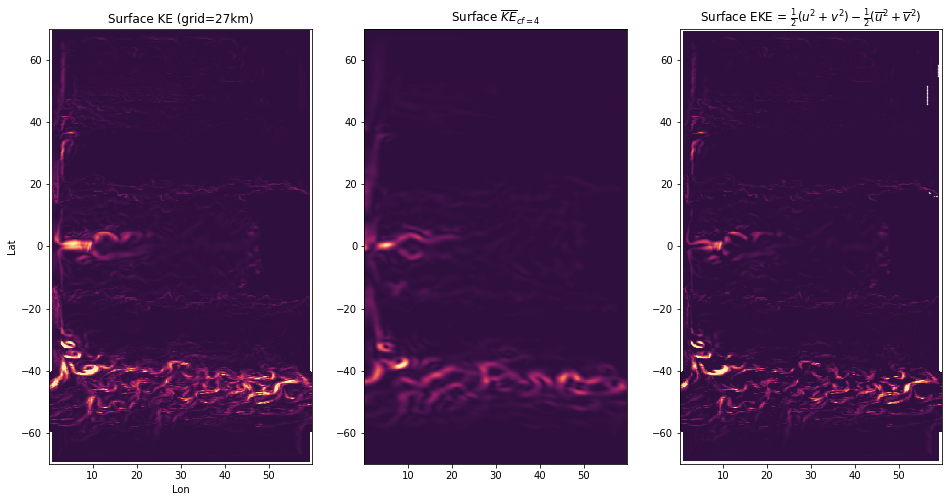

In [106]:
t_i = 10
f, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(16,8))
levs = np.linspace(7*10**(-8), 7*10**(-1), 100)
# levs = np.linspace(-1, 1, 100)
ax.pcolormesh(x1.xh, x1.yh, x1.KE.values[t_i, 0], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
ax.set_title('Surface KE (grid=' + str(np.int(dxMin/1000)) + 'km)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

ax2.pcolormesh(x1.xh, x1.yh, \
               (0.5)*(u_filtered_latlon_grid[t, :, :]**2 + v_filtered_latlon_grid[t, :, :]**2), \
               cmap = cmocean.cm.matter_r, zorder=0, vmin=levs[0], vmax=levs[-1])
ax2.set_title('Surface $\overline{KE}_{cf=4}$')

ke_0 = (0.5)*(u_reg[t_i, :, :]**2 + v_reg[t_i, :, :]**2)
filt_ke = (0.5)*(u_filtered_latlon_grid[t, :, :]**2 + v_filtered_latlon_grid[t, :, :]**2)
eke = ke_0 - filt_ke
ax3.pcolormesh(x1.xh, x1.yh, eke, cmap = cmocean.cm.matter_r, zorder=0, vmin=levs[0], vmax=levs[-1])
ax3.set_title(r'Surface EKE = $\frac{1}{2}(u^2 + v^2) - \frac{1}{2}(\overline{u}^2 + \overline{v}^2)$')

ke_0_all = (0.5)*(u_reg**2 + v_reg**2)
filt_ke_all = (0.5)*(u_filtered_latlon_grid**2 + v_filtered_latlon_grid**2)
eke_all = ke_0_all - filt_ke_all
eke_rat = ((np.nanmean(ke_0_all, axis=0) - np.nanmean(eke_all, axis=0))/(np.nanmean(ke_0_all, axis=0))).flatten()
eke_neg = np.where(eke_rat > 10)[0]
Lon, Lat = np.meshgrid(lon, lat)
ax3.scatter(Lon.flatten()[eke_neg], Lat.flatten()[eke_neg], color='#F5FFFA', s=.1)
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/neverworld_eke_cf4', dpi=400)

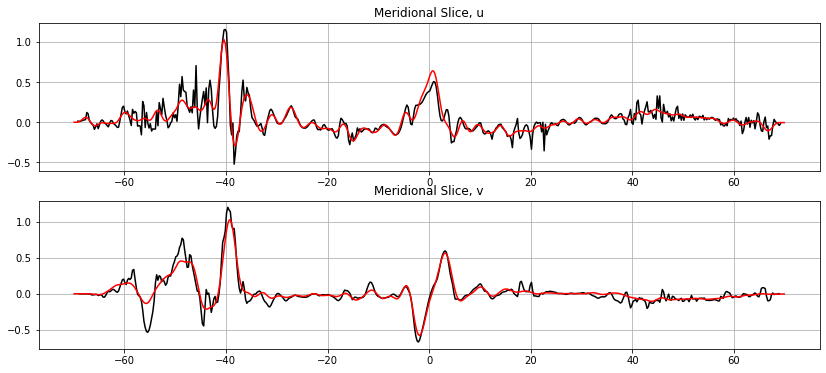

In [107]:
# check slice (look if filtering is working)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))
ax1.plot(lat, np.squeeze(u_reg[t_i, :, lon == lon_slice]), color='k')
ax1.plot(lat, np.squeeze(u_filtered_latlon_grid[t_i, :, lon == lon_slice]), color='r')
ax1.grid()
ax1.set_title('Meridional Slice, u')
ax2.plot(lat, np.squeeze(v_reg[t_i, :, lon == lon_slice]), color='k')
ax2.plot(lat, np.squeeze(v_filtered_latlon_grid[t_i, :, lon == lon_slice]), color='r')
ax2.set_title('Meridional Slice, v')
ax2.grid()
plt.show()

In [ ]:
# load data processed below (data here is interpolated ssh along altimeter tracks)

# how to compare along-track 'measurements' with 'true' model data 
# - spectra
# - band-passed variance in 10-300 km range 


-- Take satellite tracks from satellite analysis and interpolate model fields to these points at each 5 day snapshot. Export the resulting SSH and treat at satellite in filtering library

Goal: Compare resulting KE estimate to actual model KE 

Problem: Current model resolution is 1/4 degree so if going to estimate KE from SSH gradients will be extremely coarse 
-- for now interpolate sqrt(KE) onto satellite tracks representing a speed like that calculated from along-track gradients 

The code below is run to interpolate and extract model surface fields to then process as we do with altimeter measurements 

In [83]:
# satellite tracks on model 
import pickle 
this_sat = 'j2'
filter_type = 'sharp'
load_sat = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
                            this_sat + '_' + filter_type + '_processed.p', 'rb'))
lon_sat = load_sat['lon_record']
lat_sat = load_sat['lat_record']
track_sat = load_sat['track']

In [84]:
lon_w = 10
lon_e = 45
lat_s = 20
lat_n = 50
Lon, Lat = np.meshgrid(lon, lat)
Lon_f = Lon.flatten()
Lat_f = Lat.flatten()
points = np.concatenate((Lon_f[:, None], Lat_f[:, None]), axis=1)

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


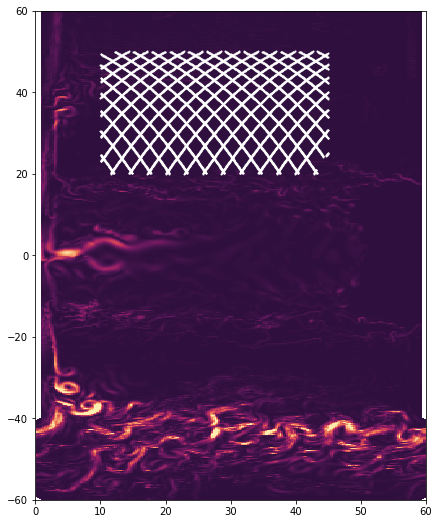

In [87]:
# --- plot and interpolate ssh (or say KE) to satellite lat/lon positions
# - say that satellite grid pattern is completed every time step...or every 5 days 
# - model fields are snapshots
lon_sim = []
lat_sim = []
dist_sim = []
e_sim = []
track = []
time_steps_i = 1  # np.shape(e)[0]  # each step is 5 days 
this_var = x1.KE.values[:, 0, :, :]

f, ax = plt.subplots(1, 1, figsize=(7,9))
levs = np.linspace(7*10**(-8), 7*10**(-1), 100)
ax.pcolormesh(x1.xh, x1.yh, x1.KE.values[-1, 0], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
count = 0
for i in tqdm(range(len(lon_sat))):  
    # satellite lon,lat coordinates (consider places on coarser grid...now on 10 km grid)
    this_lon = (lon_sat[i] - 360) + 60
    this_lat = lat_sat[i]
    lon_lat_in = np.where((this_lon > lon_w) & (this_lon < lon_e) & (this_lat > lat_s) & (this_lat < lat_n))[0]
    if (len(lon_lat_in) > 20):
        ax.scatter(this_lon[lon_lat_in], lat_sat[i][lon_lat_in], s=1, color='w', zorder=2)
        # lat/lon
        lon_sim.append(this_lon[lon_lat_in])
        lat_sim.append(lat_sat[i][lon_lat_in])
        
        dx = np.nan * np.ones(len(lat_sim[count]) - 1)
        dy = np.nan * np.ones(len(lat_sim[count]) - 1)
        for k in range(1, len(lat_sim[count])):
            dx[k - 1] = 1852 * 60 * np.cos(np.deg2rad(lat_sim[count][k])) * (lon_sim[count][k] - lon_sim[count][k - 1])
            dy[k - 1] = 1852 * 60 * (lat_sim[count][k] - lat_sim[count][k - 1]) 
        dist = np.concatenate((np.array([0]), np.sqrt(np.cumsum(dx)**2 + np.cumsum(dy)**2)))
        dist_sim.append(dist)
        
        # variable we want to interpolate 
        this_e = np.nan * np.ones((np.shape(this_var)[0], len(this_lon[lon_lat_in])))
        for j in range(time_steps_i):  # loop over each time step 
            # values = np.squeeze(e[j, 0, :, :]).flatten()
            values = np.squeeze(this_var[j, :, :]).flatten()
            this_e[j, :] = griddata(points, values, \
                                    np.concatenate((this_lon[lon_lat_in][:, None], this_lat[lon_lat_in][:, None]), \
                                                   axis=1))
        track.append(track_sat[i])
        e_sim.append(this_e)
        count = count + 1
        
ax.set_xlim([0, 60])
ax.set_ylim([-60, 60])
plt.show()

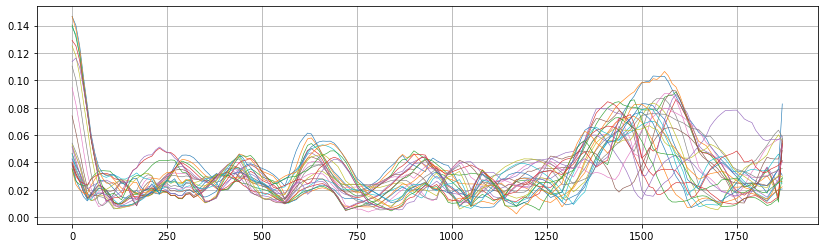

In [319]:
# dx = np.nan * np.ones(len(lat_sim[0]) - 1)
# dy = np.nan * np.ones(len(lat_sim[0]) - 1)
# for i in range(1, len(lat_sim[0])):
#     dx[i - 1] = 1852 * 60 * np.cos(np.deg2rad(lat_sim[0][i])) * (lon_sim[0][i] - lon_sim[0][i - 1])
#     dy[i - 1] = 1852 * 60 * (lat_sim[0][i] - lat_sim[0][i - 1]) 
# dist = np.concatenate((np.array([0]), np.sqrt(np.cumsum(dx)**2 + np.cumsum(dy)**2)))
test_i = 10
f, ax = plt.subplots(1, 1, figsize=(14, 4))
for i in range(np.shape(e_sim[test_i])[0]):
    ax.plot(dist_sim[test_i]/1000,np.sqrt(e_sim[test_i][i, :]), linewidth=0.6)
ax.grid()
plt.show()

In [322]:
save_sim = 0
if save_sim:
    outputs = {'dist': dist, \
               'ke': e_sim, \
                'time': time, \
                'lon': lon_sim, \
                'lat': lat_sim, \
                'track': track}
    pickle.dump(outputs, open('/Users/jakesteinberg/Desktop/neverworld/j2_simulated_ke.p', 'wb'))

In [ ]:
# tasks for analysis
# - smooth sla, u, v, ke
# - take u,v wavenumber and frequency spectra